#Equalized Odds

In [ ]:
#import income.csv and criminal_recidivism.csv from On Fairness and Calibration github
from google.colab import files
uploaded= files.upload()

Saving even_better_shap_adult.csv to even_better_shap_adult.csv


In [ ]:
import cvxpy as cvx
import numpy as np
from collections import namedtuple


class Model(namedtuple('Model', 'pred label')):
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label

    def eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)

        self_fair_pred = self.pred.copy()
        self_pp_indices, = np.nonzero(self.pred.round()) #pred.round() is 1 for >0.5, so np.nonzero gives indices of predictions which are 1
        self_pn_indices, = np.nonzero(1 - self.pred.round()) #np.nonzero gives indices of predictions which are 0
        np.random.shuffle(self_pp_indices) #in place shuffling of the indices
        np.random.shuffle(self_pn_indices)

        n2p_indices = self_pn_indices[:int(len(self_pn_indices) * sn2p)] #get the shuffled pn_indices (indices of negative predictions) upto mix rate sn2p 
        self_fair_pred[n2p_indices] = 1 - self_fair_pred[n2p_indices] #flip the predictions from raw negative (<0.5) to raw positive (>0.5)
        p2n_indices = self_pp_indices[:int(len(self_pp_indices) * (1 - sp2p))] #get the shuffled pp_indices (indices of positive predictions) upto mix rate 1-sp2p 
        self_fair_pred[p2n_indices] = 1 - self_fair_pred[p2n_indices] #flip the predictions from raw positive to raw negative

        othr_fair_pred = othr.pred.copy()
        othr_pp_indices, = np.nonzero(othr.pred.round())
        othr_pn_indices, = np.nonzero(1 - othr.pred.round())
        np.random.shuffle(othr_pp_indices)
        np.random.shuffle(othr_pn_indices)

        n2p_indices = othr_pn_indices[:int(len(othr_pn_indices) * on2p)]
        othr_fair_pred[n2p_indices] = 1 - othr_fair_pred[n2p_indices]
        p2n_indices = othr_pp_indices[:int(len(othr_pp_indices) * (1 - op2p))]
        othr_fair_pred[p2n_indices] = 1 - othr_fair_pred[p2n_indices]

        fair_self = Model(self_fair_pred, self.label)
        fair_othr = Model(othr_fair_pred, othr.label)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr

    def eq_odds_optimal_mix_rates(self, othr):
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

    def calib_eq_odds(self, other, fp_rate, fn_rate, mix_rates=None):
        if fn_rate == 0:
            self_cost = self.fp_cost()
            other_cost = other.fp_cost()
            print(self_cost, other_cost)
            self_trivial_cost = self.trivial().fp_cost()
            other_trivial_cost = other.trivial().fp_cost()
        elif fp_rate == 0:
            self_cost = self.fn_cost()
            other_cost = other.fn_cost()
            self_trivial_cost = self.trivial().fn_cost()
            other_trivial_cost = other.trivial().fn_cost()
        else:
            self_cost = self.weighted_cost(fp_rate, fn_rate)
            other_cost = other.weighted_cost(fp_rate, fn_rate)
            self_trivial_cost = self.trivial().weighted_cost(fp_rate, fn_rate)
            other_trivial_cost = other.trivial().weighted_cost(fp_rate, fn_rate)

        other_costs_more = other_cost > self_cost
        self_mix_rate = (other_cost - self_cost) / (self_trivial_cost - self_cost) if other_costs_more else 0
        other_mix_rate = 0 if other_costs_more else (self_cost - other_cost) / (other_trivial_cost - other_cost)

        # New classifiers
        self_indices = np.random.permutation(len(self.pred))[:int(self_mix_rate * len(self.pred))]
        self_new_pred = self.pred.copy()
        self_new_pred[self_indices] = self.base_rate()
        calib_eq_odds_self = Model(self_new_pred, self.label)

        other_indices = np.random.permutation(len(other.pred))[:int(other_mix_rate * len(other.pred))]
        other_new_pred = other.pred.copy()
        other_new_pred[other_indices] = other.base_rate()
        calib_eq_odds_other = Model(other_new_pred, other.label)

        if mix_rates is None:
            return calib_eq_odds_self, calib_eq_odds_other, (self_mix_rate, other_mix_rate)
        else:
            return calib_eq_odds_self, calib_eq_odds_other

    def trivial(self):
        """
        Given a classifier, produces the trivial classifier
        (i.e. a model that just returns the base rate for every prediction)
        """
        base_rate = self.base_rate()
        pred = np.ones(len(self.pred)) * base_rate
        return Model(pred, self.label)

    def weighted_cost(self, fp_rate, fn_rate):
        """
        Returns the weighted cost
        If fp_rate = 1 and fn_rate = 0, returns self.fp_cost
        If fp_rate = 0 and fn_rate = 1, returns self.fn_cost
        If fp_rate and fn_rate are nonzero, returns fp_rate * self.fp_cost * (1 - self.base_rate) +
            fn_rate * self.fn_cost * self.base_rate
        """
        norm_const = float(fp_rate + fn_rate) if (fp_rate != 0 and fn_rate != 0) else 1
        res = fp_rate / norm_const * self.fp_cost() * (1 - self.base_rate()) + \
            fn_rate / norm_const * self.fn_cost() * self.base_rate()
        return res

    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [ ]:
"""
Demo
"""

"""
To run the demo:

```
python eq_odds.py <path_to_model_predictions.csv>
```

`<path_to_model_predictions.csv>` should contain the following columns for the VALIDATION set:

- `prediction` (a score between 0 and 1)
- `label` (ground truth - either 0 or 1)
- `group` (group assignment - either 0 or 1)

Try the following experiments, which were performed in the paper:
```
python eq_odds.py data/income.csv
python eq_odds.py data/health.csv
python eq_odds.py data/criminal_recidivism.csv
```
"""
import pandas as pd
import sys

def equalized_odds(dataset):
  # Load the validation set scores from csvs
  data_filename = dataset
  test_and_val_data = pd.read_csv(data_filename)#sys.argv[1])

  # Randomly split the data into two sets - one for computing the fairness constants
  order = np.random.permutation(len(test_and_val_data)) #randomizes the list of indices
  val_indices = order[0::2] #get even index elements (the elements themselves are the original indices), i.e. starting from 0 with a step of 2
  test_indices = order[1::2] #get odd numbered index elements, i.e. starting from 1 with a step of 2
  val_data = test_and_val_data.iloc[val_indices]
  test_data = test_and_val_data.iloc[test_indices]

  # Create model objects - one for each group, validation and test
  group_0_val_data = val_data[val_data['group'] == 0]
  group_1_val_data = val_data[val_data['group'] == 1]
  group_0_test_data = test_data[test_data['group'] == 0]
  group_1_test_data = test_data[test_data['group'] == 1]

  group_0_val_model = Model(group_0_val_data['prediction'].to_numpy(), group_0_val_data['label'].to_numpy())
  group_1_val_model = Model(group_1_val_data['prediction'].to_numpy(), group_1_val_data['label'].to_numpy())
  group_0_test_model = Model(group_0_test_data['prediction'].to_numpy(), group_0_test_data['label'].to_numpy())
  group_1_test_model = Model(group_1_test_data['prediction'].to_numpy(), group_1_test_data['label'].to_numpy())

  # Find mixing rates for equalized odds models
  _, _, mix_rates = Model.eq_odds(group_0_val_model, group_1_val_model)

  # Apply the mixing rates to the test models
  eq_odds_group_0_test_model, eq_odds_group_1_test_model = Model.eq_odds(group_0_test_model,
                                                                          group_1_test_model,
                                                                          mix_rates)

  # Print results on test model
  print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
  print('Original group 1 model:\n%s\n' % repr(group_1_test_model))
  print('Equalized odds group 0 model:\n%s\n' % repr(eq_odds_group_0_test_model))
  print('Equalized odds group 1 model:\n%s\n' % repr(eq_odds_group_1_test_model))

  #Plotting the convex hulls
  from scipy.spatial import ConvexHull
  import matplotlib.pyplot as plt
  from collections import OrderedDict

  #(group_0_test_model.tnr(), group_0_test_model.fnr())
  points = np.array([(0,0), (group_0_test_model.fpr(), group_0_test_model.tpr()), (1-group_0_test_model.fpr(), 1-group_0_test_model.tpr()) , (1,1)])
  hull = ConvexHull(points)
  mylabel = 'group 0'
  for simplex in hull.simplices:
      plt.plot(points[simplex,0], points[simplex,1], 'k-', label=mylabel)
      mylabel = "_nolegend_"

  points = np.array([(0,0), (group_1_test_model.fpr(), group_1_test_model.tpr()), (1-group_1_test_model.fpr(), 1-group_1_test_model.tpr()), (1,1)])
  hull = ConvexHull(points)
  mylabel = 'group 1'
  for simplex in hull.simplices:
      plt.plot(points[simplex,0], points[simplex,1], 'r-', label=mylabel)
      mylabel = "_nolegend_"
      
  plt.plot(group_0_test_model.fpr(), group_0_test_model.tpr(), 'k+', label="Original Group 0")
  plt.plot(group_1_test_model.fpr(), group_1_test_model.tpr(), 'r+', label="Original Group 1")
  plt.plot(eq_odds_group_0_test_model.fpr(), eq_odds_group_0_test_model.tpr(), 'k*', label="Eq Odds Group 0")
  plt.plot(eq_odds_group_1_test_model.fpr(), eq_odds_group_1_test_model.tpr(), 'r*', label="Eq Odds Group 1")

  plt.plot(0, 0, 'g+')

  plt.ylabel('Y = 1')
  plt.xlabel('Y = 0')
  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
  plt.show()

Original group 0 model:
Accuracy:	0.822
F.P. cost:	0.392
F.N. cost:	0.178
Base rate:	0.702
Avg. score:	0.694

Original group 1 model:
Accuracy:	0.926
F.P. cost:	0.446
F.N. cost:	0.080
Base rate:	0.887
Avg. score:	0.867

Equalized odds group 0 model:
Accuracy:	0.822
F.P. cost:	0.392
F.N. cost:	0.178
Base rate:	0.702
Avg. score:	0.694

Equalized odds group 1 model:
Accuracy:	0.829
F.P. cost:	0.420
F.N. cost:	0.180
Base rate:	0.887
Avg. score:	0.775



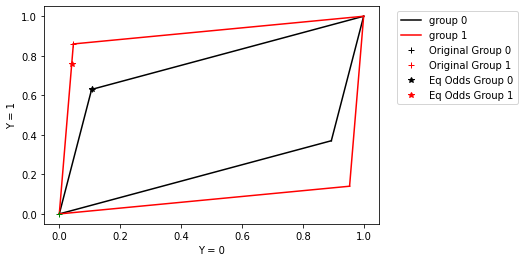

In [ ]:
equalized_odds("income.csv")

Original group 0 model:
Accuracy:	0.671
F.P. cost:	0.358
F.N. cost:	0.533
Base rate:	0.395
Avg. score:	0.401

Original group 1 model:
Accuracy:	0.652
F.P. cost:	0.447
F.N. cost:	0.429
Base rate:	0.515
Avg. score:	0.511

Equalized odds group 0 model:
Accuracy:	0.613
F.P. cost:	0.427
F.N. cost:	0.495
Base rate:	0.395
Avg. score:	0.458

Equalized odds group 1 model:
Accuracy:	0.615
F.P. cost:	0.429
F.N. cost:	0.476
Base rate:	0.515
Avg. score:	0.478



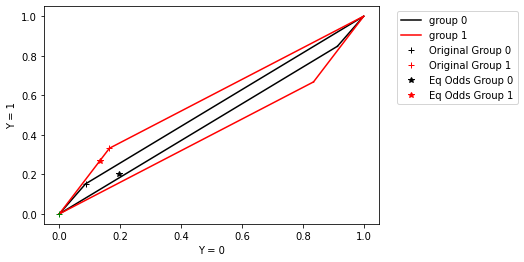

In [ ]:
equalized_odds("criminal_recidivism.csv")

#Calibrated Equalized Odds

In [ ]:
"""
`<cost_constraint>` defines the cost constraint to match for the groups. It can be:
- `fnr` - match false negatives across groups
- `fpr` - match false positives across groups
- `weighted` - match a weighted combination of false positives and false negatives

`<path_to_model_predictions.csv>` should contain the following columns for the VALIDATION set:

- `prediction` (a score between 0 and 1)
- `label` (ground truth - either 0 or 1)
- `group` (group assignment - either 0 or 1)


```
"""
import pandas as pd
import sys

def calibrated_equalized_odds(dataset, cost_constraint):
  # Cost constraint
  cost_constraint = cost_constraint#'weighted'#sys.argv[2]
  if cost_constraint not in ['fnr', 'fpr', 'weighted']:
      raise RuntimeError('cost_constraint (arg #2) should be one of fnr, fpr, weighted')

  if cost_constraint == 'fnr':
      fn_rate = 1
      fp_rate = 0
  elif cost_constraint == 'fpr':
      fn_rate = 0
      fp_rate = 1
  elif cost_constraint == 'weighted':
      fn_rate = 1
      fp_rate = 1

  # Load the validation set scores from csvs
  data_filename = dataset#"criminal_recidivism.csv"#"income.csv"#sys.argv[1]
  test_and_val_data = pd.read_csv(dataset)#sys.argv[1])

  # Randomly split the data into two sets - one for computing the fairness constants
  order = np.random.permutation(len(test_and_val_data))
  val_indices = order[0::2]
  test_indices = order[1::2]
  val_data = test_and_val_data.iloc[val_indices]
  test_data = test_and_val_data.iloc[test_indices]

  # Create model objects - one for each group, validation and test
  group_0_val_data = val_data[val_data['group'] == 0]
  group_1_val_data = val_data[val_data['group'] == 1]
  group_0_test_data = test_data[test_data['group'] == 0]
  group_1_test_data = test_data[test_data['group'] == 1]

  group_0_val_model = Model(group_0_val_data['prediction'].to_numpy(), group_0_val_data['label'].to_numpy())
  group_1_val_model = Model(group_1_val_data['prediction'].to_numpy(), group_1_val_data['label'].to_numpy())
  group_0_test_model = Model(group_0_test_data['prediction'].to_numpy(), group_0_test_data['label'].to_numpy())
  group_1_test_model = Model(group_1_test_data['prediction'].to_numpy(), group_1_test_data['label'].to_numpy())

  # Find mixing rates for equalized odds models
  _, _, mix_rates = Model.calib_eq_odds(group_0_val_model, group_1_val_model, fp_rate, fn_rate)

  # Apply the mixing rates to the test models
  calib_eq_odds_group_0_test_model, calib_eq_odds_group_1_test_model = Model.calib_eq_odds(group_0_test_model,
                                                                                            group_1_test_model,
                                                                                            fp_rate, fn_rate,
                                                                                            mix_rates)

  # Print results on test model
  print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
  print('Original group 1 model:\n%s\n' % repr(group_1_test_model))
  print('Equalized odds group 0 model:\n%s\n' % repr(calib_eq_odds_group_0_test_model))
  print('Equalized odds group 1 model:\n%s\n' % repr(calib_eq_odds_group_1_test_model))
  
  
  #Plotting the convex hulls
  from scipy.spatial import ConvexHull
  import matplotlib.pyplot as plt
  from collections import OrderedDict

  #(group_0_test_model.tnr(), group_0_test_model.fnr())
  points = np.array([(0,0), (group_0_test_model.fpr(), group_0_test_model.tpr()), (1-group_0_test_model.fpr(), 1-group_0_test_model.tpr()) , (1,1)])
  hull = ConvexHull(points)
  mylabel = 'group 0'
  for simplex in hull.simplices:
      plt.plot(points[simplex,0], points[simplex,1], 'k-', label=mylabel)
      mylabel = "_nolegend_"

  points = np.array([(0,0), (group_1_test_model.fpr(), group_1_test_model.tpr()), (1-group_1_test_model.fpr(), 1-group_1_test_model.tpr()), (1,1)])
  hull = ConvexHull(points)
  mylabel = 'group 1'
  for simplex in hull.simplices:
      plt.plot(points[simplex,0], points[simplex,1], 'r-', label=mylabel)
      mylabel = "_nolegend_"
      
  plt.plot(group_0_test_model.fpr(), group_0_test_model.tpr(), 'k+', label="Original Group 0")
  plt.plot(group_1_test_model.fpr(), group_1_test_model.tpr(), 'r+', label="Original Group 1")
  plt.plot(calib_eq_odds_group_0_test_model.fpr(), calib_eq_odds_group_0_test_model.tpr(), 'k*', label="Calib Eq Odds Group 0")
  plt.plot(calib_eq_odds_group_1_test_model.fpr(), calib_eq_odds_group_1_test_model.tpr(), 'r*', label="Calib Eq Odds Group 1")

  plt.plot(0, 0, 'g+')

  plt.ylabel('Y = 1')
  plt.xlabel('Y = 0')
  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
  plt.show()

Original group 0 model:
Accuracy:	0.816
F.P. cost:	0.398
F.N. cost:	0.178
Base rate:	0.700
Avg. score:	0.695

Original group 1 model:
Accuracy:	0.932
F.P. cost:	0.458
F.N. cost:	0.074
Base rate:	0.898
Avg. score:	0.879

Equalized odds group 0 model:
Accuracy:	0.816
F.P. cost:	0.398
F.N. cost:	0.178
Base rate:	0.700
Avg. score:	0.695

Equalized odds group 1 model:
Accuracy:	0.898
F.P. cost:	0.898
F.N. cost:	0.102
Base rate:	0.898
Avg. score:	0.898



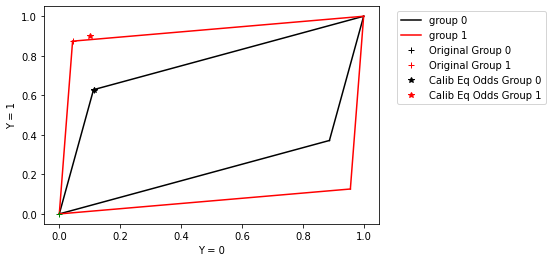

In [ ]:
calibrated_equalized_odds("income.csv", "weighted")

Original group 0 model:
Accuracy:	0.673
F.P. cost:	0.358
F.N. cost:	0.529
Base rate:	0.397
Avg. score:	0.403

Original group 1 model:
Accuracy:	0.635
F.P. cost:	0.454
F.N. cost:	0.437
Base rate:	0.498
Avg. score:	0.509

Equalized odds group 0 model:
Accuracy:	0.646
F.P. cost:	0.372
F.N. cost:	0.563
Base rate:	0.397
Avg. score:	0.398

Equalized odds group 1 model:
Accuracy:	0.635
F.P. cost:	0.454
F.N. cost:	0.437
Base rate:	0.498
Avg. score:	0.509



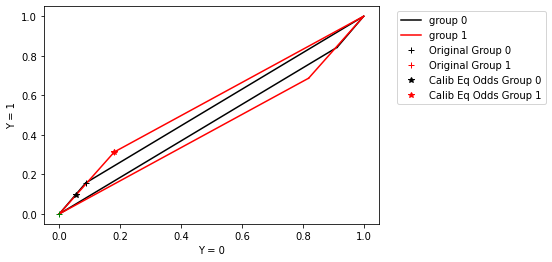

In [ ]:
calibrated_equalized_odds("criminal_recidivism.csv", "weighted")

#Equalized Odds with SHAP

In [ ]:
import cvxpy as cvx
import numpy as np
from collections import namedtuple

class Model(namedtuple('Model', 'id shap pred label')):
  
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label
    
    def trivial(self):
        """
        Given a classifier, produces the trivial classifier
        (i.e. a model that just returns the base rate for every prediction)
        """
        base_rate = self.base_rate()
        pred = np.ones(len(self.pred)) * base_rate
        return Model(self.id, self.shap, pred, self.label)

    def weighted_cost(self, fp_rate, fn_rate, w_fp = 1, w_fn = 1):
        """
        Returns the weighted cost
        If fp_rate = 1 and fn_rate = 0, returns self.fp_cost
        If fp_rate = 0 and fn_rate = 1, returns self.fn_cost
        If fp_rate and fn_rate are nonzero, returns fp_rate * self.fp_cost * (1 - self.base_rate) +
            fn_rate * self.fn_cost * self.base_rate
        """
        norm_const = float(w_fp *fp_rate + w_fn *fn_rate) if (fp_rate != 0 and fn_rate != 0) else 1
        res = w_fp*fp_rate / norm_const * self.fp_cost() * (1 - self.base_rate()) + \
            w_fn*fn_rate / norm_const * self.fn_cost() * self.base_rate()
        return res
    
    def calib_eq_odds(self, other, fp_rate, fn_rate, shap_enabled =  False, mix_rates=None):
        if mix_rates is None:
          if fn_rate == 0:
              self_cost = self.fp_cost()
              other_cost = other.fp_cost()
              print(self_cost, other_cost)
              self_trivial_cost = self.trivial().fp_cost()
              other_trivial_cost = other.trivial().fp_cost()
          elif fp_rate == 0:
              self_cost = self.fn_cost()
              other_cost = other.fn_cost()
              self_trivial_cost = self.trivial().fn_cost()
              other_trivial_cost = other.trivial().fn_cost()
          else:
              w_fp =1
              w_fn =1
              self_cost = self.weighted_cost(fp_rate, fn_rate, w_fp, w_fn)
              other_cost = other.weighted_cost(fp_rate, fn_rate, w_fp, w_fn)
              self_trivial_cost = self.trivial().weighted_cost(fp_rate, fn_rate, w_fp, w_fn)
              other_trivial_cost = other.trivial().weighted_cost(fp_rate, fn_rate, w_fp, w_fn)

          other_costs_more = other_cost > self_cost
          self_mix_rate = (other_cost - self_cost) / (self_trivial_cost - self_cost) if other_costs_more else 0
          other_mix_rate = 0 if other_costs_more else (self_cost - other_cost) / (other_trivial_cost - other_cost)
          print("The mix_rates are ", self_mix_rate, other_mix_rate)
        else:
          self_mix_rate = mix_rates[0]
          other_mix_rate = mix_rates[1]
        # New classifiers
        if shap_enabled:
          self_changed_id, self_new_pred = self.shap_fair_individuals_calibrated(self_mix_rate, advantaged  = True)
        else:
          self_changed_id, self_new_pred = self.randomized_fair_individuals_calibrated(self_mix_rate)
        
        
       
          
        calib_eq_odds_self = Model(self_changed_id, self.shap, self_new_pred, self.label)
        
        if self_mix_rate >0:
          print("Changing SELF Model--------------- for self mix rate ", self_mix_rate)
          df = self.get_pandas_df()          
          df.plot.scatter(x ='shap', y='pred')
          plt.axhline(y=self.base_rate(), color='r', linestyle='-')
          plt.title("Choosing " +str(len(self_changed_id)) + " Individuals from " + str(len(self_changed_id)) + "individuals")
          plt.show()
        else:
          print("Number of people with equal predictions in self " , np.sum(self_new_pred==self.pred))

        if shap_enabled:
          other_changed_id, other_new_pred = other.shap_fair_individuals_calibrated(other_mix_rate, advantaged = False)
        else:
          other_changed_id, other_new_pred = other.randomized_fair_individuals_calibrated(other_mix_rate)
        sns.set(rc={'figure.figsize':(5.7,5.27)})

        
          
        calib_eq_odds_other = Model(other_changed_id, other.shap, other_new_pred, other.label)
    
        if other_mix_rate >0:
          print("Changing Other Model--------------- for other mix rate ", other_mix_rate)
          df = other.get_pandas_df()
          sns.set(rc={'figure.figsize':(12.7,8.27)})
          df.plot.scatter(x ='shap', y='pred')
          plt.axhline(y=other.base_rate(), color='g', linestyle='--', linewidth = 5)
          plt.axvline(x=0, color='g', linestyle='--', linewidth = 5)
          plt.xlim(-0.1, 0.1)
          plt.title("Need to choose " +str(len(other_changed_id)) + " people from " + str(len(other.shap)) + " individuals")
          plt.show()
        else:
          print("Number of people with equal predictions in self " , np.sum(other_new_pred==other.pred))
        

        if mix_rates is None:
            return calib_eq_odds_self, calib_eq_odds_other, (self_mix_rate, other_mix_rate)
        else:
            return calib_eq_odds_self, calib_eq_odds_other
          
    def shap_fair_individuals_calibrated(self, mix_rate , advantaged):
        total = len(self.id)
        num_changed =int(mix_rate * total)
        df = self.get_pandas_df()
        print("In SHAP Method Number of people changed %d and total number %d " % (num_changed, total) )

        base_rate = self.base_rate()
        if advantaged:
          if mix_rate > 0:
            print("Redistributing Predictions for Advantaged Group")
          changed_indices = df.sort_values('shap', ascending = False).index[:num_changed]
          df.loc[changed_indices, 'pred'] = self.base_rate()

        else:
          if mix_rate > 0:
            print("Redistributing Predictions for Dis Advantaged Group")
            
          quadrant_1 = df[(df['shap'] > 0) & (df['pred'] > base_rate)].index
          quadrant_2 = df[(df['shap'] < 0) & (df['pred'] > base_rate)].index
          quadrant_3 = df[(df['shap'] <= 0) & (df['pred'] <= base_rate)].index
          quadrant_4 = df[(df['shap'] >= 0)& (df['pred'] <= base_rate)].index
          df['distance'] =  np.sqrt(np.square(df['shap']) + np.square(df['pred'] - base_rate))  
          print("Number of people in each quadrant ", len(quadrant_1),len(quadrant_2),len(quadrant_3),len(quadrant_4))
          
          required_changed_ids = num_changed
          print(required_changed_ids)
          changed_indices1 = (list(df.loc[(quadrant_1.union(quadrant_3))].sort_values('distance', ascending = False).index[:required_changed_ids]))
          print("People taken from Quadrant 1 and 3 ", len(changed_indices1))
          required_changed_ids -= len(changed_indices1)
          print("ID 's left to take  Adfter Quadrant 1 and 3 ", required_changed_ids)
          changed_indices2 = list(df.loc[quadrant_2.union(quadrant_4)].sort_values('distance', ascending = True).index[:required_changed_ids])
          required_changed_ids -= len(changed_indices2)
          print("Number of ids changed in the end ", len(changed_indices2))
          changed_indices = changed_indices1+ changed_indices2
            
          df.loc[changed_indices, 'pred'] = self.base_rate()
        return changed_indices, df.pred.copy()
    
    
    
    def randomized_fair_individuals_calibrated(self, mix_rate):
        total = len(self.id)
        changed_indices = np.random.permutation(self.id)[:int(mix_rate * total)]

        df = self.get_pandas_df()
        
        df.loc[changed_indices, 'pred'] = self.base_rate()

        return changed_indices, df.pred.copy() 

    def randomized_fair_individuals_equalized(self, p2p, n2p):
        from sklearn.utils import shuffle

        df = self.get_pandas_df()
        df['pred_outcome'] = df['pred'].round()
        original_pos =  df[df['pred_outcome'] == 1]
        # Changing positive predictions
        no_p2n= int(original_pos.shape[0] *  (1 - p2p))
        original_pos =  shuffle(original_pos)     
        p2n_indices = original_pos.head(no_p2n).index
        df.loc[p2n_indices, 'pred'] = 1 - df.loc[p2n_indices, 'pred']      
        
        #Changing negative predictions
        original_neg = df[df['pred_outcome']==0]
        no_n2p= int(original_neg.shape[0] *  (n2p))
        n2p_indices = original_neg.head(no_n2p).index
        df.loc[n2p_indices, 'pred'] = 1 - df.loc[n2p_indices, 'pred']      

        changed_ids = np.append(n2p_indices, p2n_indices)
        return changed_ids, df.pred.copy()

    def shap_fair_individuals_equalized(self, p2p, n2p):

        df = self.get_pandas_df()
        df['pred_outcome'] = df['pred'].round()
        original_pos =  df[df['pred_outcome'] == 1]
        # Changing positive predictions
        # Flipping positive predictions for people with lowest prediction without their race
        no_p2n= int(original_pos.shape[0] *  (1 - p2p))
        original_pos['pred_except_race_shap'] = original_pos['pred']-original_pos['shap']
        p2n_indices = np.asarray(original_pos.sort_values('pred_except_race_shap', ascending = True).index[:no_p2n])
        df.loc[p2n_indices, 'pred'] = 1 - df.loc[p2n_indices, 'pred']      
        
        #Changing negative predictions
        # Flipping Negative Predictions for people with highest contribution except SHAP
        original_neg = df[df['pred_outcome']==0]
        no_n2p= int(original_neg.shape[0] *  (n2p))
        original_neg['pred_except_race_shap'] = original_neg['pred']-original_neg['shap']
        n2p_indices = np.asarray(original_neg.sort_values('pred_except_race_shap', ascending = False).index[:no_n2p])
        df.loc[n2p_indices, 'pred'] = 1 - df.loc[n2p_indices, 'pred']      

        changed_ids = np.append(n2p_indices, p2n_indices)
        return changed_ids, df.pred.copy()
    
    def get_pandas_df(self):
        a = pd.DataFrame({'id':self.id, 'shap':self.shap,'label':self.label, 'pred':self.pred})
        a.set_index('id', inplace =  True)
        return a
        
    def get_changed_id(self):
      return self.id

    def eq_odds(self, other, shap_enabled =  False, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(other)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)

        df_self = self.get_pandas_df()
        if shap_enabled:
           print("using SHAP based selection of individuals for self ")
           self_changed_id, self_fair_pred = self.shap_fair_individuals_equalized(sp2p, sn2p)
      
        else:
          print("using random based selection of individuals for self ")
          self_changed_id, self_fair_pred = self.randomized_fair_individuals_equalized(sp2p, sn2p)

        df_other =  other.get_pandas_df()

        if shap_enabled:
          print("using SHAP based selection of individuals for other ")
          other_changed_id, other_fair_pred = other.shap_fair_individuals_equalized(op2p,on2p)
        else:
          print("using  random selection of individuals for other ")
          other_changed_id, other_fair_pred = other.randomized_fair_individuals_equalized(op2p,on2p)

        fair_self = Model(self_changed_id, self.shap, self_fair_pred, self.label)
        fair_other = Model(other_changed_id, other.shap, other_fair_pred, other.label)
  
        if not has_mix_rates:
            return fair_self, fair_other, mix_rates
        else:
            return fair_self, fair_other

    def eq_odds_optimal_mix_rates(self, othr):
      
        """Function to calculate mix rates for equalized odds"""
        np.random.seed(34)
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

      

    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [ ]:
"""
Demo
"""

"""
To run the demo:

```
python eq_odds.py <path_to_model_predictions.csv>
```

`<path_to_model_predictions.csv>` should contain the following columns for the VALIDATION set:

- `prediction` (a score between 0 and 1)
- `label` (ground truth - either 0 or 1)
- `group` (group assignment - either 0 or 1)

Try the following experiments, which were performed in the paper:
```
python eq_odds.py data/income.csv
python eq_odds.py data/health.csv
python eq_odds.py data/criminal_recidivism.csv
```
"""
import pandas as pd
import sys
import matplotlib.pyplot as plt

def equalized_odds_shap(dataset, shap_enabled=False):
  # Load the validation set scores from csvs
  data_filename = dataset
  test_and_val_data = pd.read_csv(data_filename)
  np.random.seed(42)
  # Randomly split the data into two sets - one for computing the fairness constants
  order = np.random.permutation(len(test_and_val_data)) #randomizes the list of indices
  val_indices = order[0::2] #get even index elements (the elements themselves are the original indices), i.e. starting from 0 with a step of 2
  test_indices = order[1::2] #get odd numbered index elements, i.e. starting from 1 with a step of 2
  val_data = test_and_val_data.iloc[val_indices]
  test_data = test_and_val_data.iloc[test_indices]

  # Create model objects - one for each group, validation and test
  group_0_val_data = val_data[val_data['group'] == 0]
  group_1_val_data = val_data[val_data['group'] == 1]
  group_0_test_data = test_data[test_data['group'] == 0]
  group_1_test_data = test_data[test_data['group'] == 1]

  group_0_val_model = Model(group_0_val_data['id'].to_numpy(),  group_0_val_data['shap'].to_numpy(), 
                            group_0_val_data['prediction'].to_numpy(), group_0_val_data['label'].to_numpy())
  group_1_val_model = Model(group_1_val_data['id'].to_numpy(),  group_1_val_data['shap'].to_numpy(),
                            group_1_val_data['prediction'].to_numpy(), group_1_val_data['label'].to_numpy())
  group_0_test_model = Model(group_0_test_data['id'].to_numpy(), group_0_test_data['shap'].to_numpy(),
                             group_0_test_data['prediction'].to_numpy(), group_0_test_data['label'].to_numpy())
  group_1_test_model = Model(group_1_test_data['id'].to_numpy(), group_1_test_data['shap'].to_numpy(),
                             group_1_test_data['prediction'].to_numpy(), group_1_test_data['label'].to_numpy())

  # Find mixing rates for equalized odds models
  _, _, mix_rates = Model.eq_odds(group_0_val_model, group_1_val_model)

  # Apply the mixing rates to the test models
  eq_odds_group_0_test_model, eq_odds_group_1_test_model = Model.eq_odds(group_0_test_model,
                                                                          group_1_test_model, 
                                                                         shap_enabled,
                                                                          mix_rates)

  # Print results on test model
  print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
  print('Original group 1 model:\n%s\n' % repr(group_1_test_model))
  print('Equalized odds group 0 model:\n%s\n' % repr(eq_odds_group_0_test_model))
  print('Equalized odds group 1 model:\n%s\n' % repr(eq_odds_group_1_test_model))

  #Plotting the convex hulls
  from scipy.spatial import ConvexHull
  import matplotlib.pyplot as plt
  from collections import OrderedDict

  #(group_0_test_model.tnr(), group_0_test_model.fnr())
  points = np.array([(0,0), (group_0_test_model.fpr(), group_0_test_model.tpr()), (1-group_0_test_model.fpr(), 1-group_0_test_model.tpr()) , (1,1)])
  hull = ConvexHull(points)
  mylabel = 'group 0'
  for simplex in hull.simplices:
      plt.plot(points[simplex,0], points[simplex,1], 'k-', label=mylabel)
      mylabel = "_nolegend_"

  points = np.array([(0,0), (group_1_test_model.fpr(), group_1_test_model.tpr()), (1-group_1_test_model.fpr(), 1-group_1_test_model.tpr()), (1,1)])
  hull = ConvexHull(points)
  mylabel = 'group 1'
  for simplex in hull.simplices:
      plt.plot(points[simplex,0], points[simplex,1], 'r-', label=mylabel)
      mylabel = "_nolegend_"
      
  plt.plot(group_0_test_model.fpr(), group_0_test_model.tpr(), 'k+', label="Original Group 0")
  plt.plot(group_1_test_model.fpr(), group_1_test_model.tpr(), 'r+', label="Original Group 1")
  plt.plot(eq_odds_group_0_test_model.fpr(), eq_odds_group_0_test_model.tpr(), 'k*', label="Eq Odds Group 0")
  plt.plot(eq_odds_group_1_test_model.fpr(), eq_odds_group_1_test_model.tpr(), 'r*', label="Eq Odds Group 1")

  plt.plot(0, 0, 'g+')

  plt.ylabel('Y = 1')
  plt.xlabel('Y = 0')
  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
  plt.show()

  print("TPR and FPR difference before post processing {} {}".format((group_1_test_model.tpr() - group_0_test_model.tpr()), ((group_1_test_model.fpr() - group_0_test_model.fpr()))))
  print("TPR and FPR difference before post processing {} {}".format((eq_odds_group_1_test_model.tpr() - eq_odds_group_0_test_model.tpr()), ((eq_odds_group_1_test_model.fpr() - eq_odds_group_0_test_model.fpr()))))

using random based selection of individuals for self 
using  random selection of individuals for other 
using SHAP based selection of individuals for self 
using SHAP based selection of individuals for other 
Original group 0 model:
Accuracy:	0.668
F.P. cost:	0.492
F.N. cost:	0.358
Base rate:	0.582
Avg. score:	0.579

Original group 1 model:
Accuracy:	0.680
F.P. cost:	0.360
F.N. cost:	0.459
Base rate:	0.448
Avg. score:	0.441

Equalized odds group 0 model:
Accuracy:	0.660
F.P. cost:	0.480
F.N. cost:	0.369
Base rate:	0.582
Avg. score:	0.568

Equalized odds group 1 model:
Accuracy:	0.666
F.P. cost:	0.378
F.N. cost:	0.442
Base rate:	0.448
Avg. score:	0.459



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

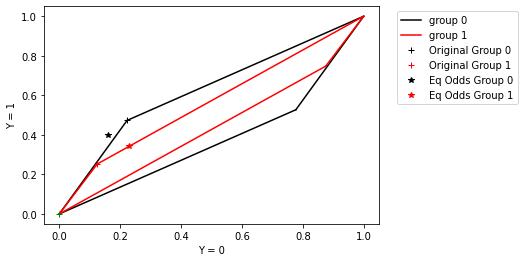

TPR and FPR difference before post processing -0.22054362180302645 -0.09807606101358146
TPR and FPR difference before post processing -0.05692945153200307 0.07126752201989361


In [ ]:
equalized_odds_shap("potential_shap_compas.csv", shap_enabled=True)

using random based selection of individuals for self 
using  random selection of individuals for other 
using random based selection of individuals for self 
using  random selection of individuals for other 
Original group 0 model:
Accuracy:	0.668
F.P. cost:	0.492
F.N. cost:	0.358
Base rate:	0.582
Avg. score:	0.579

Original group 1 model:
Accuracy:	0.680
F.P. cost:	0.360
F.N. cost:	0.459
Base rate:	0.448
Avg. score:	0.441

Equalized odds group 0 model:
Accuracy:	0.629
F.P. cost:	0.465
F.N. cost:	0.415
Base rate:	0.582
Avg. score:	0.535

Equalized odds group 1 model:
Accuracy:	0.612
F.P. cost:	0.462
F.N. cost:	0.419
Base rate:	0.448
Avg. score:	0.515



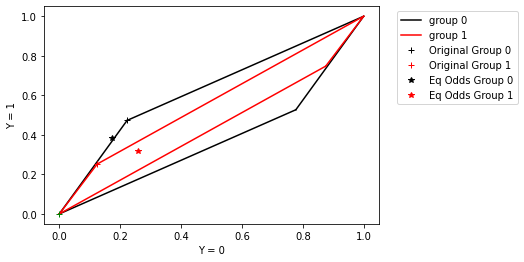

TPR and FPR difference before post processing -0.22054362180302645 -0.09807606101358146
TPR and FPR difference before post processing -0.06838827705690648 0.08272634754479702


In [ ]:
equalized_odds_shap("potential_shap_compas.csv", shap_enabled=False)

using random based selection of individuals for self 
using  random selection of individuals for other 
using SHAP based selection of individuals for self 
using SHAP based selection of individuals for other 
Original group 0 model:
Accuracy:	0.839
F.P. cost:	0.165
F.N. cost:	0.366
Base rate:	0.317
Avg. score:	0.314

Original group 1 model:
Accuracy:	0.934
F.P. cost:	0.061
F.N. cost:	0.444
Base rate:	0.117
Avg. score:	0.119

Equalized odds group 0 model:
Accuracy:	0.835
F.P. cost:	0.164
F.N. cost:	0.368
Base rate:	0.317
Avg. score:	0.313

Equalized odds group 1 model:
Accuracy:	0.885
F.P. cost:	0.108
F.N. cost:	0.355
Base rate:	0.117
Avg. score:	0.171



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

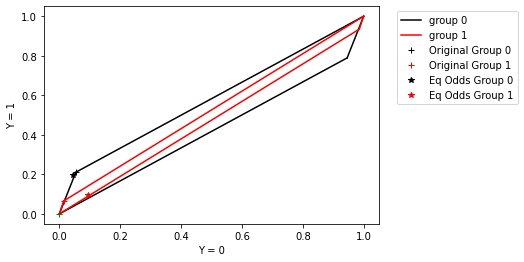

TPR and FPR difference before post processing -0.14529756558211432 -0.039838116002279864
TPR and FPR difference before post processing -0.10030906756913294 0.04994860601518041


In [ ]:
equalized_odds_shap("even_better_shap_adult.csv", shap_enabled=True)

using random based selection of individuals for self 
using  random selection of individuals for other 
using random based selection of individuals for self 
using  random selection of individuals for other 
Original group 0 model:
Accuracy:	0.839
F.P. cost:	0.165
F.N. cost:	0.366
Base rate:	0.317
Avg. score:	0.314

Original group 1 model:
Accuracy:	0.934
F.P. cost:	0.061
F.N. cost:	0.444
Base rate:	0.117
Avg. score:	0.119

Equalized odds group 0 model:
Accuracy:	0.825
F.P. cost:	0.163
F.N. cost:	0.403
Base rate:	0.317
Avg. score:	0.301

Equalized odds group 1 model:
Accuracy:	0.833
F.P. cost:	0.169
F.N. cost:	0.423
Base rate:	0.117
Avg. score:	0.216



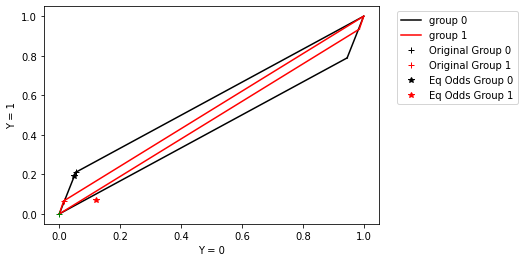

TPR and FPR difference before post processing -0.14529756558211432 -0.039838116002279864
TPR and FPR difference before post processing -0.12081003828090166 0.07044957672694915


In [ ]:
equalized_odds_shap("even_better_shap_adult.csv", shap_enabled=False)

#Calibrated equalized odds with SHAP

In [ ]:
"""To run the demo:

```
python calib_eq_odds.py <path_to_model_predictions.csv> <cost_constraint>
```

`<cost_constraint>` defines the cost constraint to match for the groups. It can be:
- `fnr` - match false negatives across groups
- `fpr` - match false positives across groups
- `weighted` - match a weighted combination of false positives and false negatives

`<path_to_model_predictions.csv>` should contain the following columns for the VALIDATION set:

- `prediction` (a score between 0 and 1)
- `label` (ground truth - either 0 or 1)
- `group` (group assignment - either 0 or 1)

Try the following experiments, which were performed in the paper:
```
python calib_eq_odds.py data/income.csv fnr
python calib_eq_odds.py data/health.csv weighted
python calib_eq_odds.py data/criminal_recidivism.csv fpr
```
"""
import pandas as pd
import sys
import seaborn as sns

def calibrated_equalized_odds_shap(dataset, cost_constraint, shap_enabled=False):
  # Cost constraint
  cost_constraint = cost_constraint#'weighted'#sys.argv[2]
  if cost_constraint not in ['fnr', 'fpr', 'weighted']:
      raise RuntimeError('cost_constraint (arg #2) should be one of fnr, fpr, weighted')

  if cost_constraint == 'fnr':
      fn_rate = 1
      fp_rate = 0
  elif cost_constraint == 'fpr':
      fn_rate = 0
      fp_rate = 1
  elif cost_constraint == 'weighted':
      fn_rate = 1
      fp_rate = 1

  # Load the validation set scores from csvs
  data_filename = dataset#"criminal_recidivism.csv"#"income.csv"#sys.argv[1]
  test_and_val_data = pd.read_csv(dataset)#sys.argv[1])

  # Randomly split the data into two sets - one for computing the fairness constants
  order = np.random.permutation(len(test_and_val_data))
  val_indices = order[0::2]
  test_indices = order[1::2]
  val_data = test_and_val_data.iloc[val_indices]
  test_data = test_and_val_data.iloc[test_indices]

  # Create model objects - one for each group, validation and test
  group_0_val_data = val_data[val_data['group'] == 0]
  group_1_val_data = val_data[val_data['group'] == 1]
  group_0_test_data = test_data[test_data['group'] == 0]
  group_1_test_data = test_data[test_data['group'] == 1]

  group_0_val_model = Model(group_0_val_data['id'].to_numpy(), group_0_val_data['shap'].to_numpy(),
                            group_0_val_data['prediction'].to_numpy(), group_0_val_data['label'].to_numpy())
  group_1_val_model = Model(group_1_val_data['id'].to_numpy(), group_1_val_data['shap'].to_numpy(), 
                            group_1_val_data['prediction'].to_numpy(), group_1_val_data['label'].to_numpy())
  group_0_test_model = Model(group_0_test_data['id'].to_numpy(), group_0_test_data['shap'].to_numpy(), 
                             group_0_test_data['prediction'].to_numpy(), group_0_test_data['label'].to_numpy())
  group_1_test_model = Model(group_1_test_data['id'].to_numpy(), group_1_test_data['shap'].to_numpy(), 
                             group_1_test_data['prediction'].to_numpy(), group_1_test_data['label'].to_numpy())

  # Find mixing rates for equalized odds models
  _, _, mix_rates = Model.calib_eq_odds(group_0_val_model, group_1_val_model, fp_rate, fn_rate)

  # Apply the mixing rates to the test models
  calib_eq_odds_group_0_test_model, calib_eq_odds_group_1_test_model = Model.calib_eq_odds(group_0_test_model,
                                                                                            group_1_test_model,
                                                                                            fp_rate, fn_rate, 
                                                                                           shap_enabled,
                                                                                            mix_rates)

  # Print results on test model
  print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
  print('Original group 1 model:\n%s\n' % repr(group_1_test_model))
  print('Equalized odds group 0 model:\n%s\n' % repr(calib_eq_odds_group_0_test_model))
  print('Equalized odds group 1 model:\n%s\n' % repr(calib_eq_odds_group_1_test_model))
  
  
  #Plotting the convex hulls
  from scipy.spatial import ConvexHull
  import matplotlib.pyplot as plt
  from collections import OrderedDict

  #(group_0_test_model.tnr(), group_0_test_model.fnr())
  points = np.array([(0,0), (group_0_test_model.fpr(), group_0_test_model.tpr()), (1-group_0_test_model.fpr(), 1-group_0_test_model.tpr()) , (1,1)])
  hull = ConvexHull(points)
  mylabel = 'group 0'
  for simplex in hull.simplices:
      plt.plot(points[simplex,0], points[simplex,1], 'k-', label=mylabel)
      mylabel = "_nolegend_"

  points = np.array([(0,0), (group_1_test_model.fpr(), group_1_test_model.tpr()), (1-group_1_test_model.fpr(), 1-group_1_test_model.tpr()), (1,1)])
  hull = ConvexHull(points)
  mylabel = 'group 1'
  for simplex in hull.simplices:
      plt.plot(points[simplex,0], points[simplex,1], 'r-', label=mylabel)
      mylabel = "_nolegend_"
      
  plt.plot(group_0_test_model.fpr(), group_0_test_model.tpr(), 'k+', label="Original Group 0")
  plt.plot(group_1_test_model.fpr(), group_1_test_model.tpr(), 'r+', label="Original Group 1")
  plt.plot(calib_eq_odds_group_0_test_model.fpr(), calib_eq_odds_group_0_test_model.tpr(), 'k*', label="Calib Eq Odds Group 0")
  plt.plot(calib_eq_odds_group_1_test_model.fpr(), calib_eq_odds_group_1_test_model.tpr(), 'r*', label="Calib Eq Odds Group 1")

  plt.plot(0, 0, 'g+')

  plt.ylabel('Y = 1')
  plt.xlabel('Y = 0')
  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
  plt.show()

  print("TPR and FPR difference before post processing {} {}".format((group_1_test_model.tpr() - group_0_test_model.tpr()), ((group_1_test_model.fpr() - group_0_test_model.fpr()))))
  print("TPR and FPR difference before post processing {} {}".format((calib_eq_odds_group_1_test_model.tpr() - calib_eq_odds_group_0_test_model.tpr()), ((calib_eq_odds_group_1_test_model.fpr() - calib_eq_odds_group_0_test_model.fpr()))))
  return calib_eq_odds_group_0_test_model, calib_eq_odds_group_1_test_model


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The mix_rates are  0 0.13742262588614998
Number of people with equal predictions in self  1059
Changing Other Model--------------- for other mix rate  0.13742262588614998


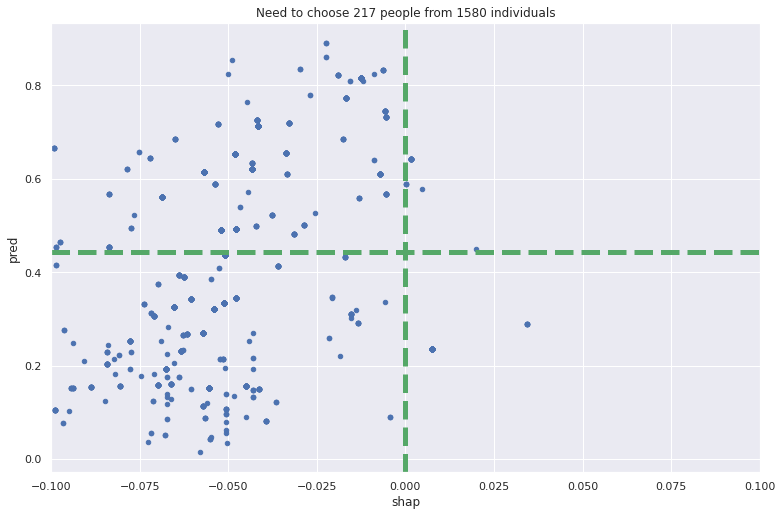

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In SHAP Method Number of people changed 0 and total number 1044 
Number of people with equal predictions in self  1044
In SHAP Method Number of people changed 219 and total number 1595 
Redistributing Predictions for Dis Advantaged Group
Number of people in each quadrant  22 772 773 28
219
People taken from Quadrant 1 and 3  219
ID 's left to take  Adfter Quadrant 1 and 3  0
Number of ids changed in the end  0
Changing Other Model--------------- for other mix rate  0.13742262588614998


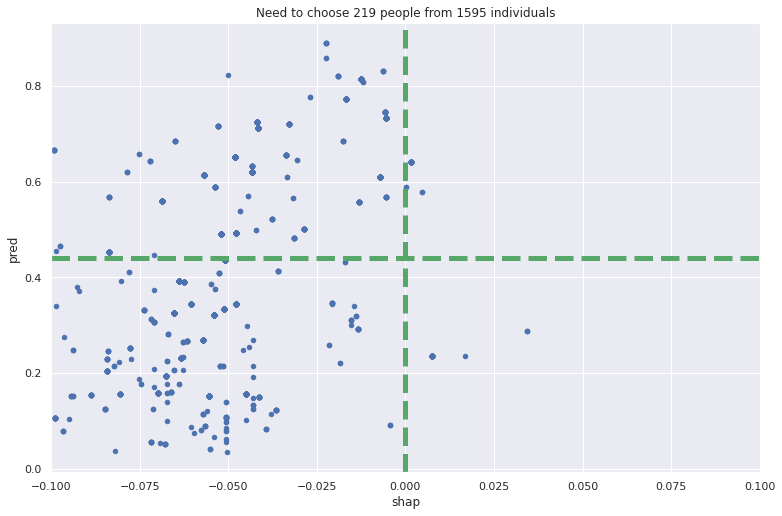

Original group 0 model:
Accuracy:	0.682
F.P. cost:	0.495
F.N. cost:	0.349
Base rate:	0.562
Avg. score:	0.582

Original group 1 model:
Accuracy:	0.690
F.P. cost:	0.358
F.N. cost:	0.459
Base rate:	0.440
Avg. score:	0.439

Equalized odds group 0 model:
Accuracy:	0.682
F.P. cost:	0.495
F.N. cost:	0.349
Base rate:	0.562
Avg. score:	0.582

Equalized odds group 1 model:
Accuracy:	0.690
F.P. cost:	0.429
F.N. cost:	0.451
Base rate:	0.440
Avg. score:	0.482



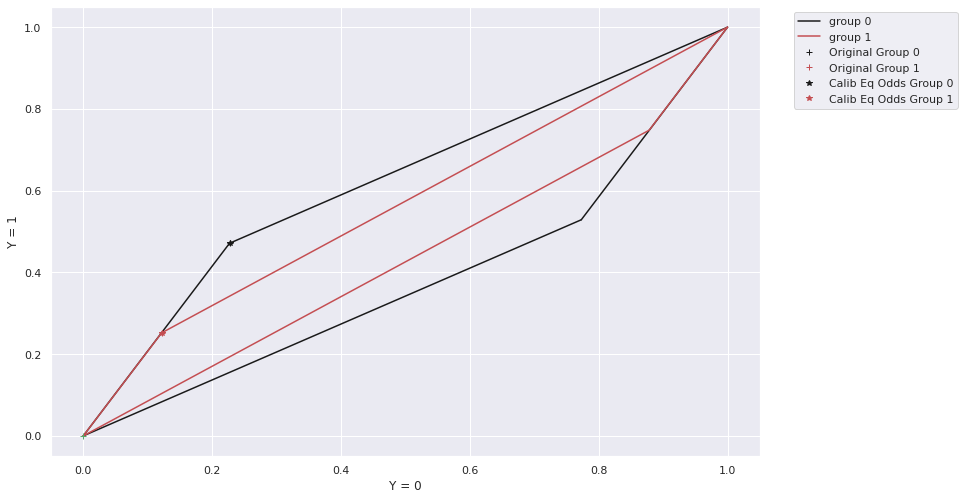

TPR and FPR difference before post processing -0.219226750261233 -0.10538140020898641
TPR and FPR difference before post processing -0.219226750261233 -0.10538140020898641


In [ ]:
calib_eq_odds_group_0_test_model_shap, calib_eq_odds_group_1_test_model_shap = calibrated_equalized_odds_shap("potential_shap_compas.csv", "weighted", shap_enabled=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The mix_rates are  0 0.1620162807987133
Number of people with equal predictions in self  1073
Changing Other Model--------------- for other mix rate  0.1620162807987133


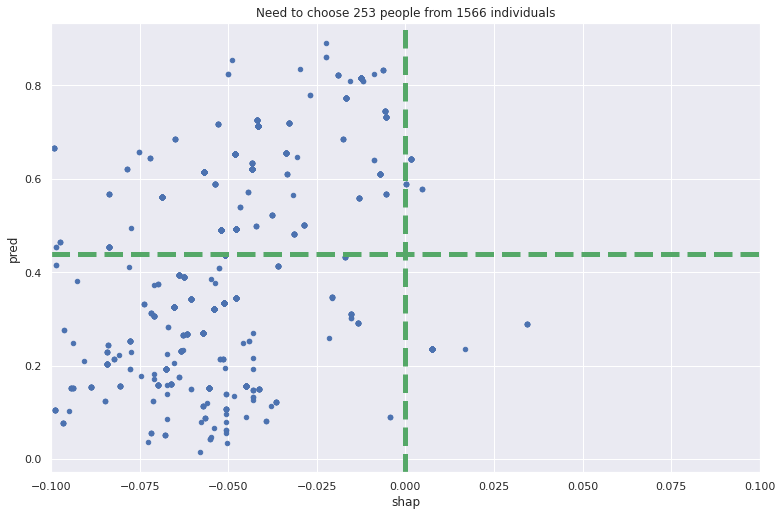

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Number of people with equal predictions in self  1030
Changing Other Model--------------- for other mix rate  0.1620162807987133


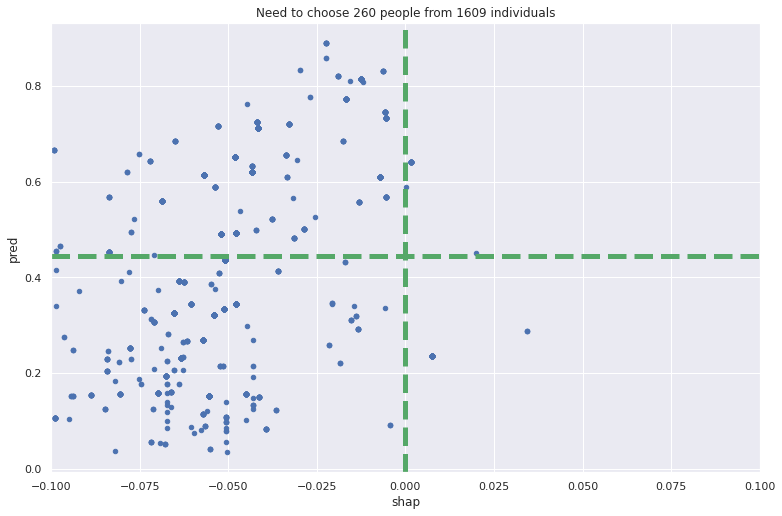

Original group 0 model:
Accuracy:	0.684
F.P. cost:	0.490
F.N. cost:	0.356
Base rate:	0.586
Avg. score:	0.580

Original group 1 model:
Accuracy:	0.687
F.P. cost:	0.361
F.N. cost:	0.456
Base rate:	0.445
Avg. score:	0.442

Equalized odds group 0 model:
Accuracy:	0.684
F.P. cost:	0.490
F.N. cost:	0.356
Base rate:	0.586
Avg. score:	0.580

Equalized odds group 1 model:
Accuracy:	0.659
F.P. cost:	0.373
F.N. cost:	0.478
Base rate:	0.445
Avg. score:	0.440



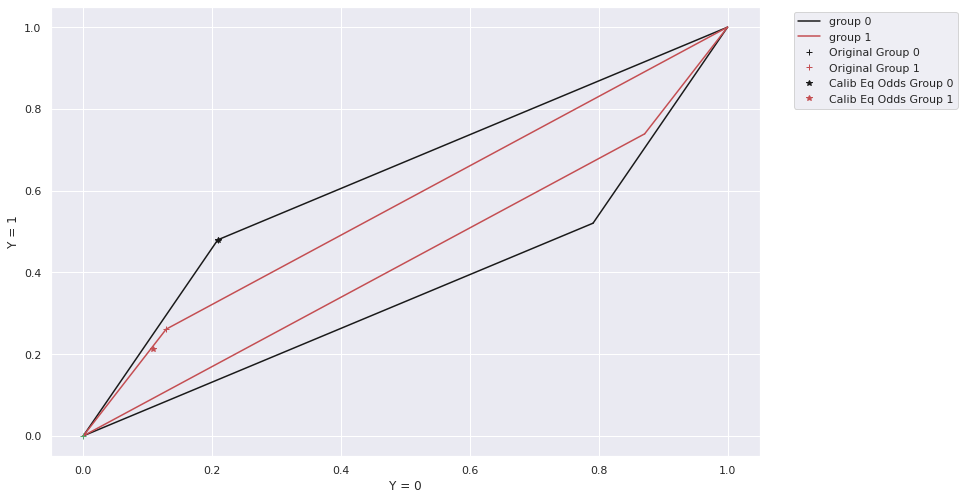

TPR and FPR difference before post processing -0.2185799537794083 -0.08008652784398437
TPR and FPR difference before post processing -0.26767877292173275 -0.1005961611566009


In [ ]:
calib_eq_odds_group_0_test_model, calib_eq_odds_group_1_test_model = calibrated_equalized_odds_shap("potential_shap_compas.csv", "weighted", shap_enabled=False)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The mix_rates are  0 1.2689625374874043
Number of people with equal predictions in self  15252
Changing Other Model--------------- for other mix rate  1.2689625374874043


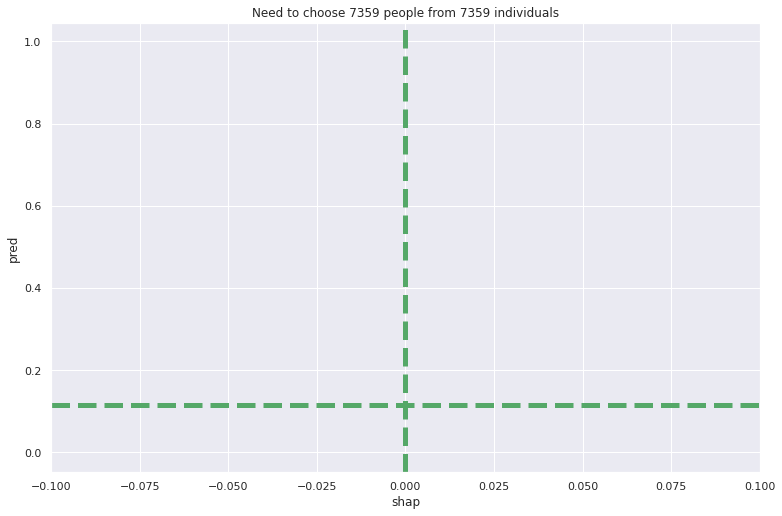

In SHAP Method Number of people changed 0 and total number 15275 
Number of people with equal predictions in self  15275
In SHAP Method Number of people changed 9309 and total number 7336 
Redistributing Predictions for Dis Advantaged Group
Number of people in each quadrant  0 1633 5703 0
9309
People taken from Quadrant 1 and 3  5703
ID 's left to take  Adfter Quadrant 1 and 3  3606
Number of ids changed in the end  1633
Changing Other Model--------------- for other mix rate  1.2689625374874043


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


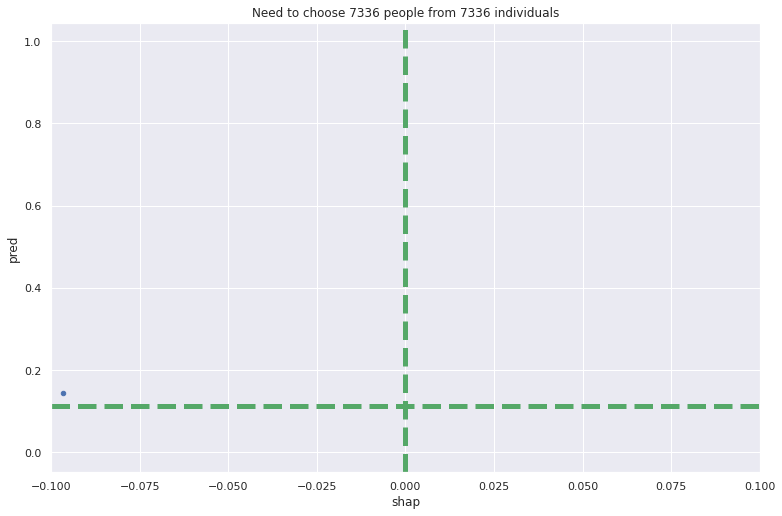

Original group 0 model:
Accuracy:	0.835
F.P. cost:	0.167
F.N. cost:	0.375
Base rate:	0.318
Avg. score:	0.313

Original group 1 model:
Accuracy:	0.933
F.P. cost:	0.061
F.N. cost:	0.452
Base rate:	0.113
Avg. score:	0.117

Equalized odds group 0 model:
Accuracy:	0.835
F.P. cost:	0.167
F.N. cost:	0.375
Base rate:	0.318
Avg. score:	0.313

Equalized odds group 1 model:
Accuracy:	0.887
F.P. cost:	0.113
F.N. cost:	0.887
Base rate:	0.113
Avg. score:	0.113



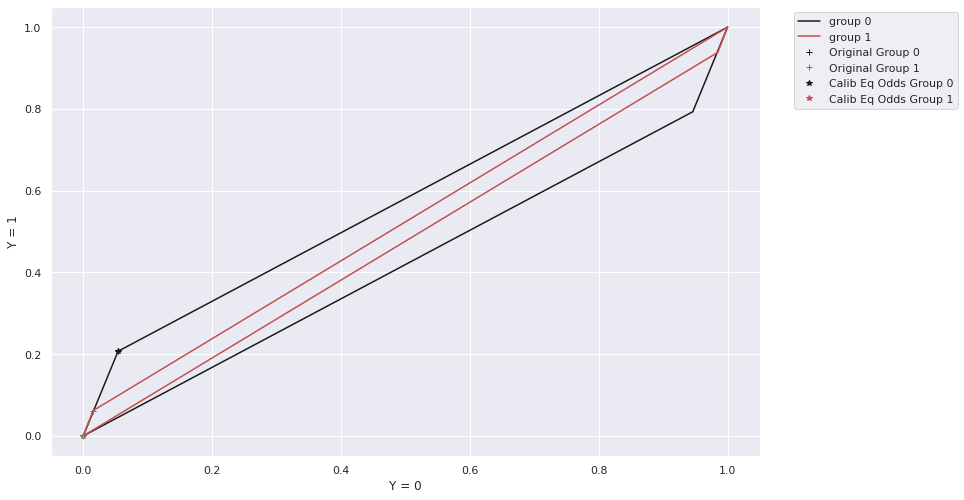

In [ ]:
calibrated_equalized_odds_shap("better_shap_adult.csv", "weighted", shap_enabled=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The mix_rates are  0.03592107877683889 0
Changing SELF Model--------------- for self mix rate  0.03592107877683889


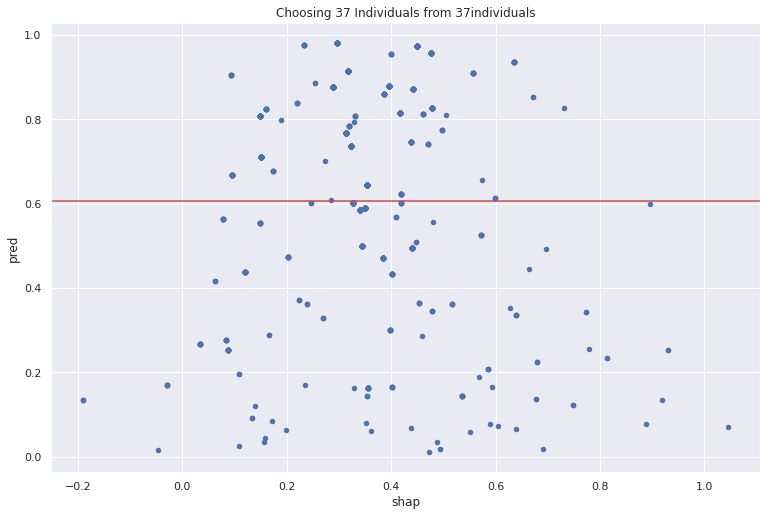

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Number of people with equal predictions in self  1604
Changing SELF Model--------------- for self mix rate  0.03592107877683889


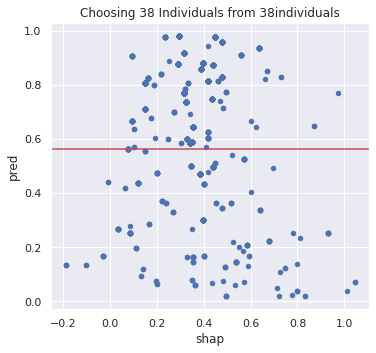

Number of people with equal predictions in self  1571
Original group 0 model:
Accuracy:	0.646
F.P. cost:	0.571
F.N. cost:	0.264
Base rate:	0.564
Avg. score:	0.664

Original group 1 model:
Accuracy:	0.678
F.P. cost:	0.334
F.N. cost:	0.458
Base rate:	0.436
Avg. score:	0.424

Equalized odds group 0 model:
Accuracy:	0.640
F.P. cost:	0.573
F.N. cost:	0.272
Base rate:	0.564
Avg. score:	0.660

Equalized odds group 1 model:
Accuracy:	0.678
F.P. cost:	0.334
F.N. cost:	0.458
Base rate:	0.436
Avg. score:	0.424



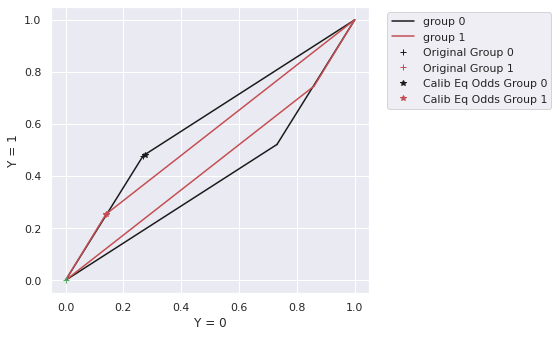

In [ ]:
calibrated_equalized_odds_shap("better_shap_compas.csv", "weighted", shap_enabled=False)

In [ ]:
def drawGraph(dataset, calib_eq_odds_group_0_test_model_shap, calib_eq_odds_group_1_test_model_shap, calib_eq_odds_group_0_test_model, calib_eq_odds_group_1_test_model):  
  test_and_val_data = pd.read_csv(dataset)
  test_and_val_data.reset_index(drop=True, inplace=True)
  shap_changed_ids = calib_eq_odds_group_1_test_model_shap.get_changed_id()
  shap_pred = test_and_val_data.loc[shap_changed_ids, 'prediction']
  shap_shap = test_and_val_data.loc[shap_changed_ids, 'shap']

  randomized_changed_ids =  calib_eq_odds_group_1_test_model.get_changed_id()
  random_pred = test_and_val_data.loc[randomized_changed_ids, 'prediction']
  random_shap = test_and_val_data.loc[randomized_changed_ids, 'shap']


  base_rate =  calib_eq_odds_group_1_test_model_shap.base_rate() 

  common_ids = set(shap_changed_ids).intersection(set(randomized_changed_ids))
  print(common_ids)
  print("The length of the unique ids in shap is %d" % len(np.unique(shap_changed_ids)))
  print("The length of the unique ids in randomized is %d" % len(np.unique(randomized_changed_ids)))
  print("The length of the unique ids in common to shap and random is %d" % len(np.unique(list(common_ids))))

  #shap_changed_data =  test_and_val_data.loc[shap_changed_ids, independent_columns + ['pred']]
  #randomized_changed_data =  test_and_val_data.loc[randomized_changed_ids, independent_columns + ['pred']]

  print("The length of the shap_shap list is %d" % len(shap_shap))
  print( len(shap_shap))

  from collections import Counter
  sns.set_style('whitegrid')
  sns.set(rc={'figure.figsize':(15.7,10.27)})
  #print(type(shap))
  weights_shap = [200*i for i in Counter(shap_shap).values() for j in range(i)]
  weights_random = [200*i for i in Counter(random_shap).values() for j in range(i)]

  sns.scatterplot(shap_shap, shap_pred, color = 'b', alpha = 0.1, s = weights_shap)
  sns.scatterplot(random_shap, random_pred, color = 'r', alpha = 0.1, s = weights_random)
  plt.xlim([-0.5,0.5])
  plt.title('Scatter Plot of Shap Value and Prediction for SHAP Fiar and Randomized')
  plt.axhline(y=base_rate, color='g', linestyle='--', linewidth = 5)
  plt.axvline(x=0, color='g', linestyle='--', linewidth = 5)

{2816, 3073, 2660, 2469, 328, 2346, 1036, 3343, 2160, 4721, 3090, 3219, 4785, 275, 4467, 2301, 798, 3583}
The length of the unique ids in shap is 219
The length of the unique ids in randomized is 260
The length of the unique ids in common to shap and random is 18
The length of the shap_shap list is 219
219


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


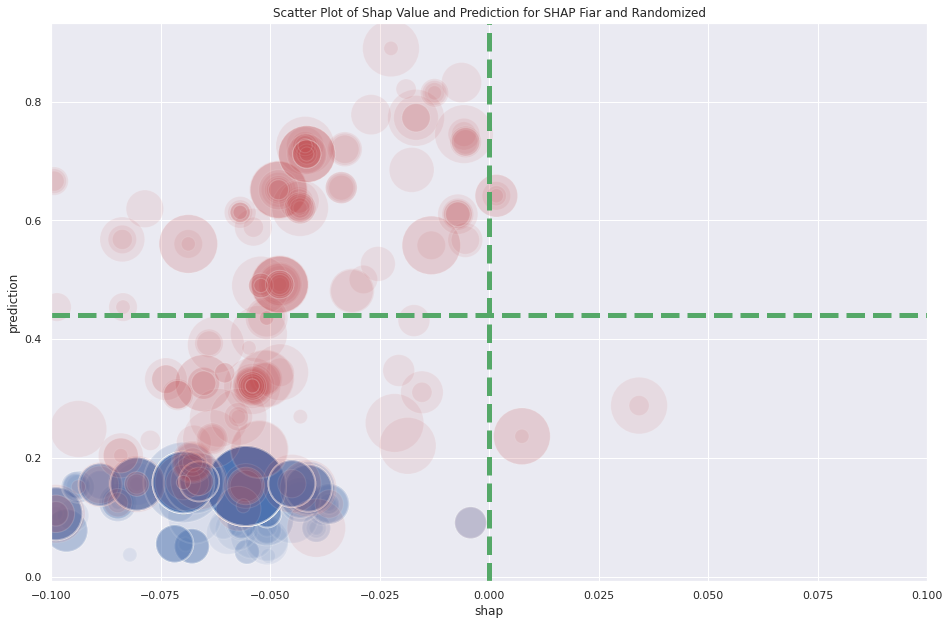

In [ ]:
drawGraph("potential_shap_compas.csv", calib_eq_odds_group_0_test_model_shap, calib_eq_odds_group_1_test_model_shap, calib_eq_odds_group_0_test_model, calib_eq_odds_group_1_test_model)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The mix_rates are  2.7156298119418847 0
Changing SELF Model--------------- for self mix rate  2.7156298119418847


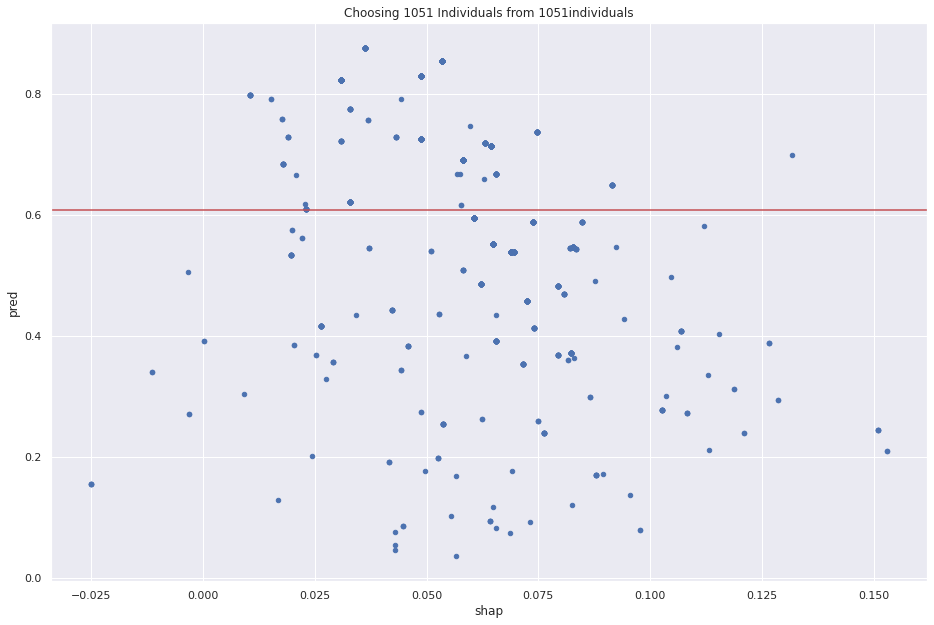

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Number of people with equal predictions in self  1588
In SHAP Method Number of people changed 2856 and total number 1052 
Redistributing Predictions for Advantaged Group
Changing SELF Model--------------- for self mix rate  2.7156298119418847


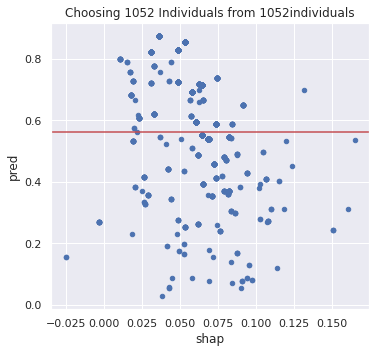

In SHAP Method Number of people changed 0 and total number 1587 
Number of people in each quadrant  25 789 737 36
0
People taken from Quadrant 1 and 3  0
ID 's left to take  Adfter Quadrant 1 and 3  0
Number of ids changed in the end  0
Number of people with equal predictions in self  1587
Original group 0 model:
Accuracy:	0.662
F.P. cost:	0.503
F.N. cost:	0.351
Base rate:	0.561
Avg. score:	0.585

Original group 1 model:
Accuracy:	0.679
F.P. cost:	0.367
F.N. cost:	0.456
Base rate:	0.454
Avg. score:	0.448

Equalized odds group 0 model:
Accuracy:	0.561
F.P. cost:	0.561
F.N. cost:	0.439
Base rate:	0.561
Avg. score:	0.561

Equalized odds group 1 model:
Accuracy:	0.679
F.P. cost:	0.367
F.N. cost:	0.456
Base rate:	0.454
Avg. score:	0.448



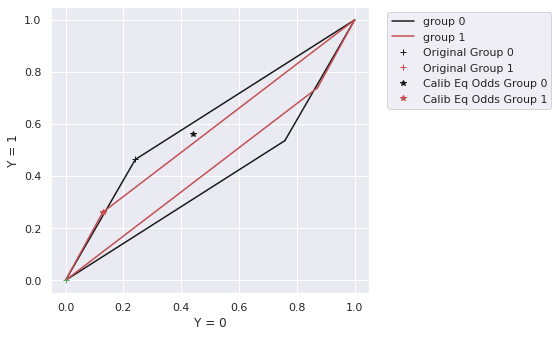

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


TPR and FPR difference before post processing -0.20300876177880645 -0.11290044347969841
TPR and FPR difference before post processing -0.29996693668374935 -0.3106190746584056
The mix_rates are  1.2048684980815896 0
Changing SELF Model--------------- for self mix rate  1.2048684980815896


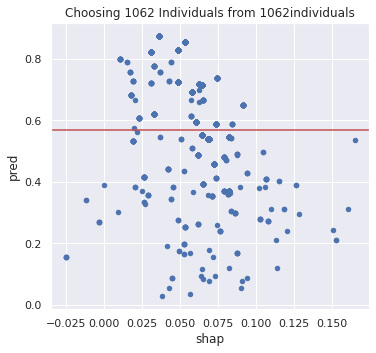

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Number of people with equal predictions in self  1577
Changing SELF Model--------------- for self mix rate  1.2048684980815896


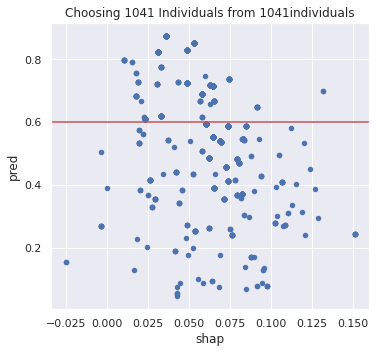

Number of people with equal predictions in self  1598
Original group 0 model:
Accuracy:	0.691
F.P. cost:	0.482
F.N. cost:	0.358
Base rate:	0.599
Avg. score:	0.578

Original group 1 model:
Accuracy:	0.684
F.P. cost:	0.362
F.N. cost:	0.463
Base rate:	0.439
Avg. score:	0.439

Equalized odds group 0 model:
Accuracy:	0.599
F.P. cost:	0.599
F.N. cost:	0.401
Base rate:	0.599
Avg. score:	0.599

Equalized odds group 1 model:
Accuracy:	0.684
F.P. cost:	0.362
F.N. cost:	0.463
Base rate:	0.439
Avg. score:	0.439



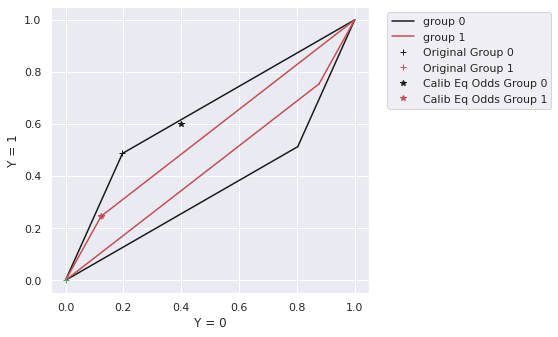

TPR and FPR difference before post processing -0.24109928476878517 -0.07364693378731098
TPR and FPR difference before post processing -0.35349121560452 -0.27729727000248866
set()
The length of the unique ids in shap is 0
The length of the unique ids in randomized is 0
The length of the unique ids in common to shap and random is 0
The length of the shap_shap list is 0
0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


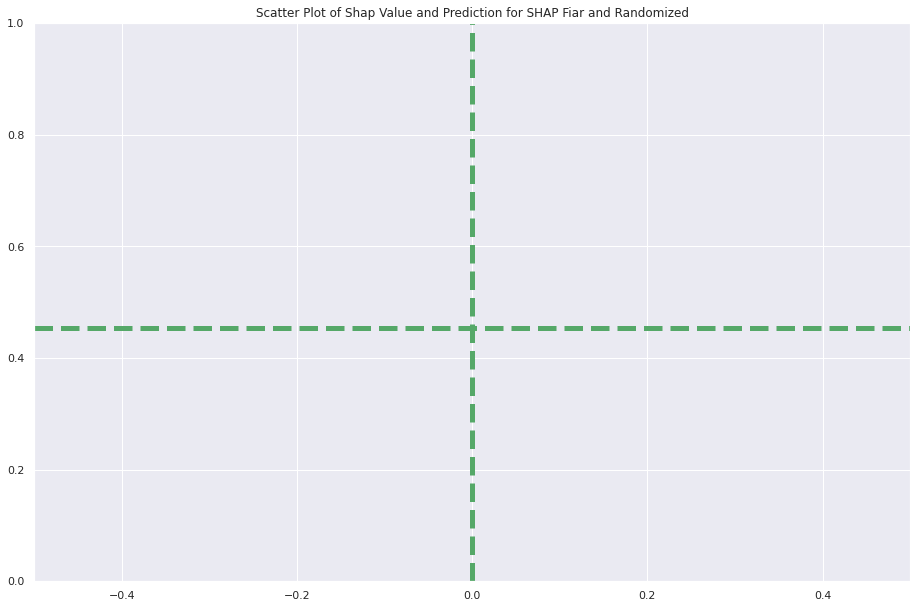

In [ ]:
dataset = "potential_shap_compas.csv"
constraint = "fnr"
drawGraph(dataset, *calibrated_equalized_odds_shap(dataset, constraint, shap_enabled=True), *calibrated_equalized_odds_shap(dataset, constraint, shap_enabled=False))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.16518654957007278 0.061312364328696585
The mix_rates are  0 2.066430679248839
Number of people with equal predictions in self  15262
Changing Other Model--------------- for other mix rate  2.066430679248839


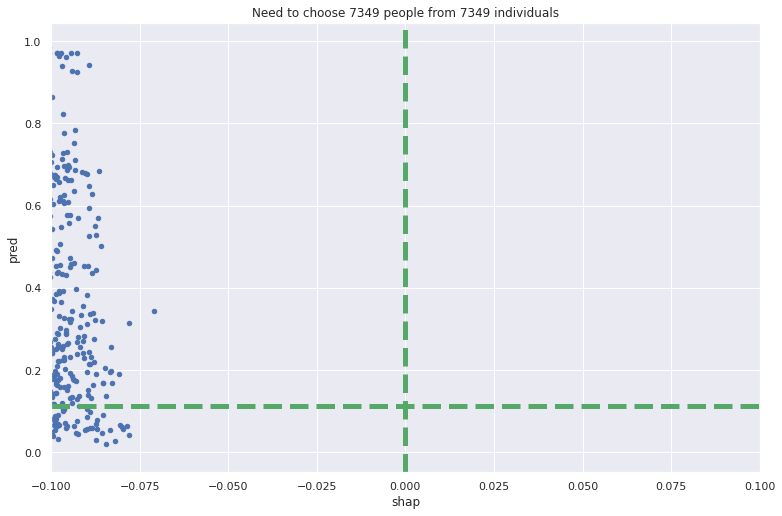

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In SHAP Method Number of people changed 0 and total number 15265 
Number of people with equal predictions in self  15265
In SHAP Method Number of people changed 15179 and total number 7346 
Redistributing Predictions for Dis Advantaged Group
Number of people in each quadrant  0 1635 5711 0
15179
People taken from Quadrant 1 and 3  5711
ID 's left to take  Adfter Quadrant 1 and 3  9468
Number of ids changed in the end  1635
Changing Other Model--------------- for other mix rate  2.066430679248839


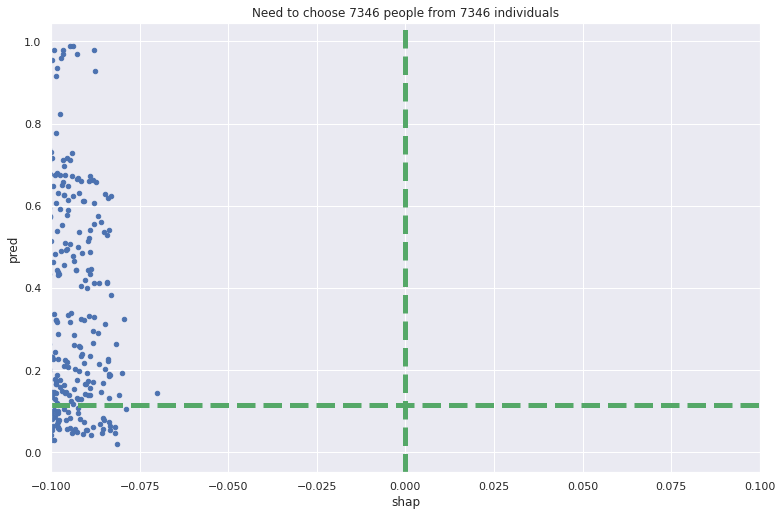

Original group 0 model:
Accuracy:	0.833
F.P. cost:	0.169
F.N. cost:	0.374
Base rate:	0.318
Avg. score:	0.314

Original group 1 model:
Accuracy:	0.935
F.P. cost:	0.060
F.N. cost:	0.451
Base rate:	0.116
Avg. score:	0.117

Equalized odds group 0 model:
Accuracy:	0.833
F.P. cost:	0.169
F.N. cost:	0.374
Base rate:	0.318
Avg. score:	0.314

Equalized odds group 1 model:
Accuracy:	0.884
F.P. cost:	0.116
F.N. cost:	0.884
Base rate:	0.116
Avg. score:	0.116



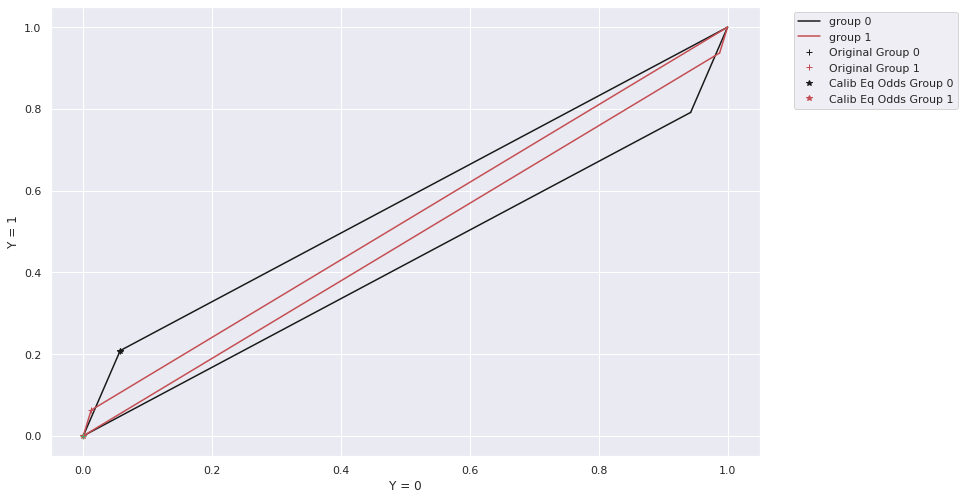

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


TPR and FPR difference before post processing -0.1455542249374402 -0.04500359338232652
TPR and FPR difference before post processing -0.2085817228955126 -0.05725515886013757
0.16814688798287258 0.06206831734309506
The mix_rates are  0 2.129529893161781
Number of people with equal predictions in self  15255
Changing Other Model--------------- for other mix rate  2.129529893161781


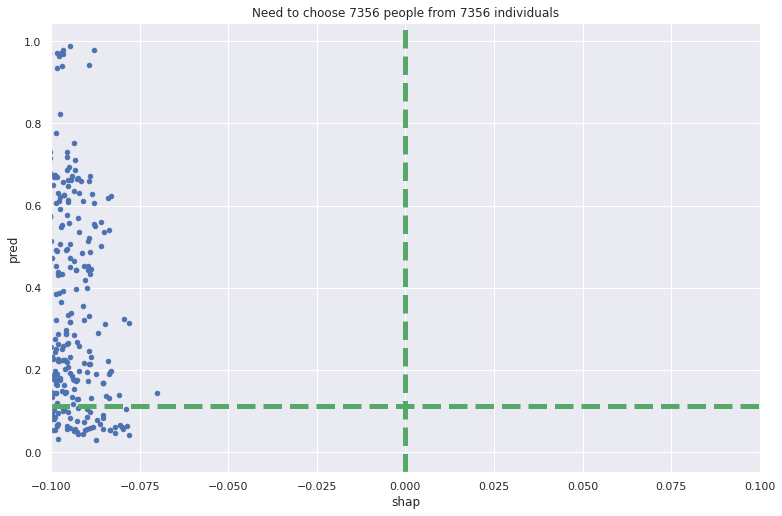

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Number of people with equal predictions in self  15272
Changing Other Model--------------- for other mix rate  2.129529893161781


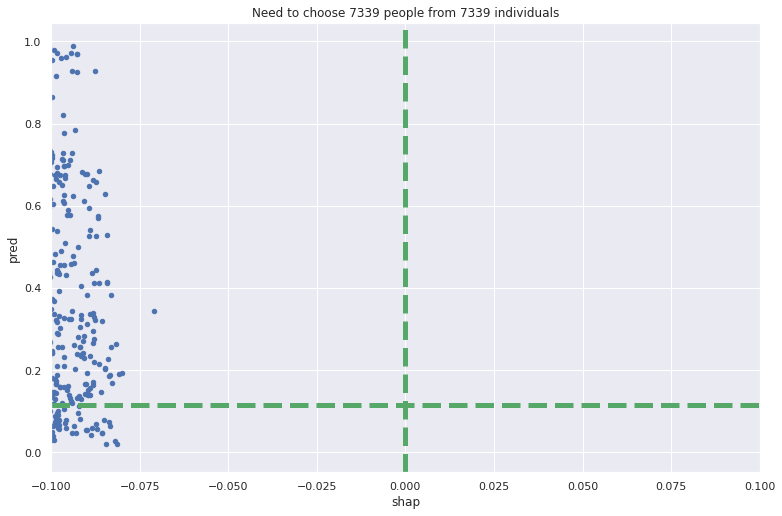

Original group 0 model:
Accuracy:	0.838
F.P. cost:	0.166
F.N. cost:	0.372
Base rate:	0.305
Avg. score:	0.307

Original group 1 model:
Accuracy:	0.938
F.P. cost:	0.059
F.N. cost:	0.439
Base rate:	0.115
Avg. score:	0.117

Equalized odds group 0 model:
Accuracy:	0.838
F.P. cost:	0.166
F.N. cost:	0.372
Base rate:	0.305
Avg. score:	0.307

Equalized odds group 1 model:
Accuracy:	0.885
F.P. cost:	0.115
F.N. cost:	0.885
Base rate:	0.115
Avg. score:	0.115



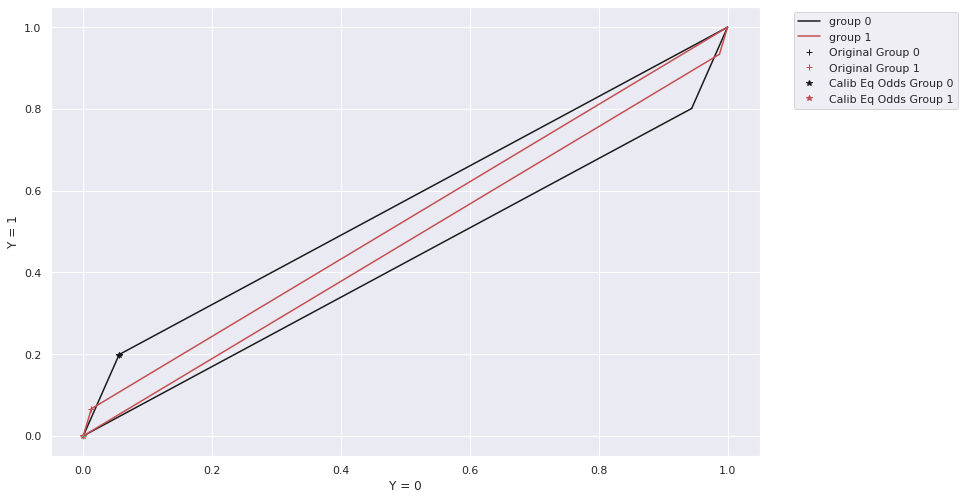

TPR and FPR difference before post processing -0.13270458326965928 -0.04312164444194784
TPR and FPR difference before post processing -0.19892613933996858 -0.05565741225772656
{24577, 4, 5, 24581, 24583, 12, 16396, 40974, 16400, 24592, 18, 16402, 24595, 24597, 16408, 32794, 8226, 24613, 32807, 24617, 32810, 16427, 24622, 8240, 24627, 32820, 16436, 24631, 24635, 32831, 16454, 24647, 75, 16461, 78, 24653, 24654, 24656, 32854, 8278, 24666, 32859, 32864, 32868, 16487, 104, 8298, 24684, 41069, 24687, 16498, 41079, 24695, 121, 8314, 16510, 24706, 32899, 24709, 24714, 140, 16526, 41109, 150, 24727, 32920, 16537, 24728, 8349, 16543, 162, 16547, 168, 32937, 24745, 32939, 41132, 24748, 16559, 8368, 32945, 16563, 41140, 8374, 183, 8376, 16568, 16570, 32955, 188, 16571, 32958, 8383, 32960, 193, 41151, 41152, 8389, 16583, 32972, 32973, 8397, 32975, 208, 209, 16589, 211, 24780, 41174, 32984, 41187, 24807, 33000, 8425, 16617, 33003, 237, 41197, 240, 16632, 8444, 16639, 41216, 24831, 259, 261, 8454, 2

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


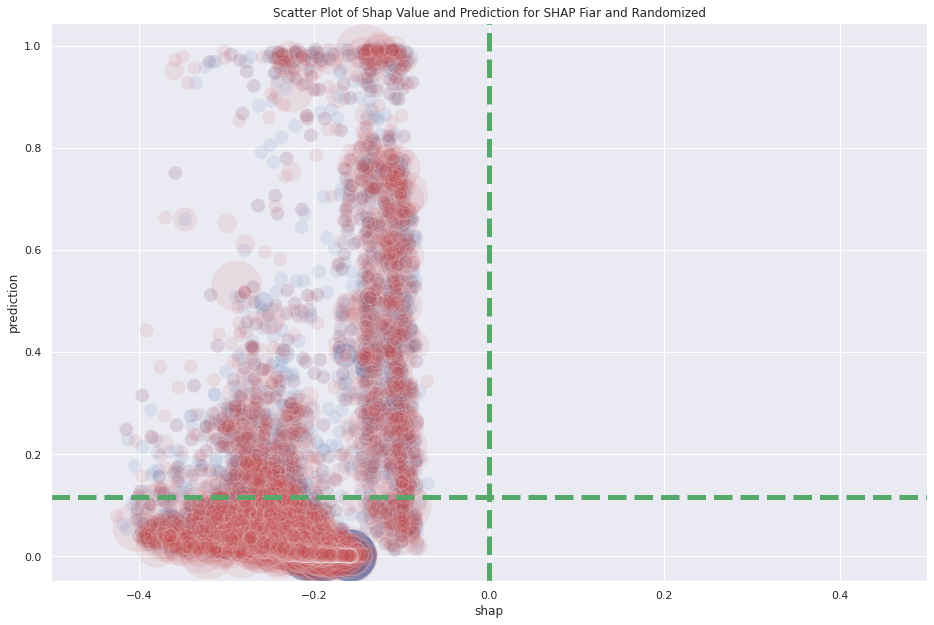

In [ ]:
dataset = "even_better_shap_adult.csv"
constraint = "fpr"
drawGraph(dataset, *calibrated_equalized_odds_shap(dataset, constraint, shap_enabled=True), *calibrated_equalized_odds_shap(dataset, constraint, shap_enabled=False))